<a href="https://colab.research.google.com/github/Taylorwutianyi/5-data-logging-readme_aws_code/blob/main/batch_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib pandas
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget -c https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-drlbebba
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-drlbebba
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=77a60df8f08c0f7ad37da711eeb99ccf1dcca6c903fa77432da3dd8e11bdc18a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x5pfdedb/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-12-04 17:06:43--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import os
import pandas as pd

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    stability_score_offset = 1.5,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [5]:
def measure_single_image(image, fname):
    masks = mask_generator.generate(image)

    def find_min_bbox(masks):
        bboxes = []
        for mask_info in masks:
            segmentation = mask_info['segmentation']
            # Ensure the mask is a numpy array and is binary
            if not isinstance(segmentation, np.ndarray) or segmentation.dtype != np.bool_:
                print("Warning: Skipping mask as 'segmentation' is not a boolean numpy array.")
                continue

            # Convert the boolean mask to uint8 for findContours
            segmentation_uint8 = segmentation.astype(np.uint8)

            # Find contours
            # Use RETR_EXTERNAL to get only the outer contours
            # Use CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments
            contours, _ = cv2.findContours(segmentation_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Find the largest contour by area if there are multiple
                largest_contour = max(contours, key=cv2.contourArea)

                # Get the rotated bounding box for the largest contour
                # The result is a Box2D structure which contains:
                #   (center_x, center_y), (width, height), angle of rotation (in degrees)
                min_bbox = cv2.minAreaRect(largest_contour)
                bboxes.append(min_bbox)
            else:
                # Handle cases where no contours are found (e.g., entirely zero mask)
                print("Warning: No contours found for a mask.")
                # Append a placeholder or None, depending on desired behavior
                # bboxes.append(None) # Or some other indicator

        return bboxes

    # Example usage (assuming 'masks' is already generated from previous code):
    rotated_bboxes = find_min_bbox(masks)

    def filter_rods(masks, rotated_bboxes, image):
        roi_list = []
        # Convert image to grayscale for thresholding
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        for i, mask_data in enumerate(masks):
            mask = mask_data['segmentation']
            # (1) Check if 90% pixels in mask in the image is black
            # Use the grayscale image for thresholding
            masked_image = gray_image[mask]
            black_thr, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Apply threshold on grayscale
            black_pixels = np.sum(masked_image < black_thr + 10)
            total_pixels = np.sum(mask)
            if total_pixels > 0 and (black_pixels / total_pixels) >= 0.9:
              # (2) Check if the pixels in mask forms an elongated shape
              # Ensure we don't go out of bounds for rotated_bboxes
                ((center_x, center_y), (width, height), angle) = rotated_bboxes[i]
                # 1. Check aspect ratio
                if width > 0 and height > 0:
                    aspect_ratio = max(width, height) / min(width, height)
                    if aspect_ratio > 3:
                        roi_list.append(i)
        return roi_list

    roi_list = filter_rods(masks, rotated_bboxes, image)

    masks_rods = [mask for i, mask in enumerate(masks) if i in roi_list]
    bboxs_rods = [bbox for i, bbox in enumerate(rotated_bboxes) if i in roi_list]

    def show_anns(image, anns, bboxs, fname):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        img[:,:,3] = 0
        for i, ann in enumerate(anns):
            area = ann['area']
            m = ann['segmentation']
            pos = ann['bbox']
            color_mask = np.concatenate([np.random.random(3), [0.4]])
            img[m] = color_mask
            plt.text(int(pos[0] + pos[2] / 2), int(pos[1] + pos[3] / 2), s=i, ha='center', va='center')
        plt.imshow(img)
        plt.savefig(f'{fname}_seg.png')

    show_anns(image, masks_rods, bboxs_rods, fname)

    def calc_effective_diameter(mask, bbox):
        """
        Calculates the effective diameter of a masked region.

        Args:
            mask (np.ndarray): A boolean numpy array representing the segmentation mask.
            bbox (tuple): The rotated bounding box of the masked region in the format
                          ((center_x, center_y), (width, height), angle).

        Returns:
            float: The effective diameter. Returns NaN if area or length is zero.
        """
        area = np.sum(mask)
        (cx, cy), (w, h), angle = bbox

        if area == 0 or max(w, h) == 0:
            return np.nan # Avoid division by zero

        effective_diameter_ellipse = 4 * area / np.pi / max(w, h)
        # effective_diameter_rec = 2 * (max(w, h) - np.sqrt(max(w, h)**2 - (4 - np.pi) * area)) / (4 - np.pi)
        effective_diameter_rec = area / max(w, h)

        return max(w, h), min(w, h), effective_diameter_ellipse, effective_diameter_rec

    def extract_side_profiles(mask, bbox, smooth_sigma=2):
        (cx, cy), (w, h), angle = bbox
        if w < h:
            angle += 90  # ensure long side is horizontal

        # Rotate mask
        rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
        rotated = cv2.warpAffine(mask.astype(np.uint8), rot_mat, (mask.shape[1], mask.shape[0]))

        # Crop to bounding box region
        # box = cv2.boxPoints(((cx, cy), (w, h), angle))
        # box = np.intp(cv2.transform(np.array([box]), rot_mat)[0])
        # x, y, w_crop, h_crop = cv2.boundingRect(box)
        # cropped = rotated[y:y+h_crop, x:x+w_crop]

        # alternative: Find bounding box of non-zero region in rotated mask (actual rod area)
        ys, xs = np.where(rotated > 0)
        x_min, x_max = np.min(xs), np.max(xs)
        y_min, y_max = np.min(ys), np.max(ys)
        cropped = rotated[y_min:y_max+1, x_min:x_max+1]

        # Extract side profiles (top and bottom for each x column)
        cols = cropped.shape[1]
        top_profile = []
        bottom_profile = []

        for i in range(cols):
            col = cropped[:, i]
            ys = np.where(col > 0)[0]
            if len(ys) > 0:
                top_profile.append(ys[0])
                bottom_profile.append(ys[-1])
            else:
                top_profile.append(np.nan)
                bottom_profile.append(np.nan)

        top_profile = np.array(top_profile)
        bottom_profile = np.array(bottom_profile)

        # Interpolate missing values (optional)
        def fill_nan(profile):
            valid = ~np.isnan(profile)
            return np.interp(np.arange(len(profile)), np.flatnonzero(valid), profile[valid])

        top_profile_filled = fill_nan(top_profile)
        bottom_profile_filled = fill_nan(bottom_profile)

        # Smooth profiles
        top_smooth = gaussian_filter1d(top_profile_filled, sigma=smooth_sigma)
        bottom_smooth = gaussian_filter1d(bottom_profile_filled, sigma=smooth_sigma)

        # Detect protrusions (peaks and valleys)
        top_peaks, _ = find_peaks(-top_smooth, distance=10, prominence=0.5)
        top_valleys, _ = find_peaks(top_smooth, distance=10, prominence=0.5)
        bottom_peaks, _ = find_peaks(bottom_smooth, distance=10, prominence=0.5)
        bottom_valleys, _ = find_peaks(-bottom_smooth, distance=10, prominence=0.5)

        # Compute spacings
        spacing_top = np.diff(top_peaks)
        spacing_bottom = np.diff(bottom_peaks)
        spacing = np.concatenate([spacing_top, spacing_bottom])

        # Depth: distance from valleys to their corresponding edge (top or bottom)
        depth_top = top_smooth[top_valleys] - np.min(top_smooth)
        depth_bottom = np.max(bottom_smooth) - bottom_smooth[bottom_valleys]
        depth = np.concatenate([depth_top, depth_bottom])

        return max(w, h), min(w, h), spacing, depth, len(spacing)

    measurements = pd.DataFrame(columns=['#', 'rod_w', 'rod_h', 'rod_eff_d_ellipse', 'rod_eff_d_rec', 'dip_cnt', 'dip_sp_avg', 'dip_sp_std', 'dip_de_avg', 'dip_de_std'])

    for i, (mask_rod, bbox_rod) in enumerate(zip(masks_rods, bboxs_rods)):
        # Extract the segmentation mask from the mask dictionary
        segmentation_mask = mask_rod['segmentation']

        # Call extract_side_profiles for each pair of mask and bbox
        w, h, d_ellipse, d_rec = calc_effective_diameter(segmentation_mask, bbox_rod)
        w, h, spacing, depth, cnt = extract_side_profiles(segmentation_mask, bbox_rod)

        # Concatenate the returned spacing and depth (which is a numpy array)
        measurements.loc[i] = [i, w, h, d_ellipse, d_rec, cnt, np.mean(spacing), np.std(spacing), np.mean(depth), np.std(depth)]
    return measurements

Processing image: 3.tif
Processing image: 4.tif
Total number of detected rods: 49

Average length of rod: 165.18, STD length of rod: 12.52

Average width of rod: 37.92, STD width of rod: 3.23

Average effective ellipse diameter of rod: 40.40, STD: 3.95

Average effective rectangular diameter of rod: 33.20, STD: 3.47

Average number of dips per rod: 3.53, STD of number of dips per rod: 1.19

Average of spacing: 65.50, STD of spacing: 28.67
Average of depth: 4.46, STD of depth: 2.18



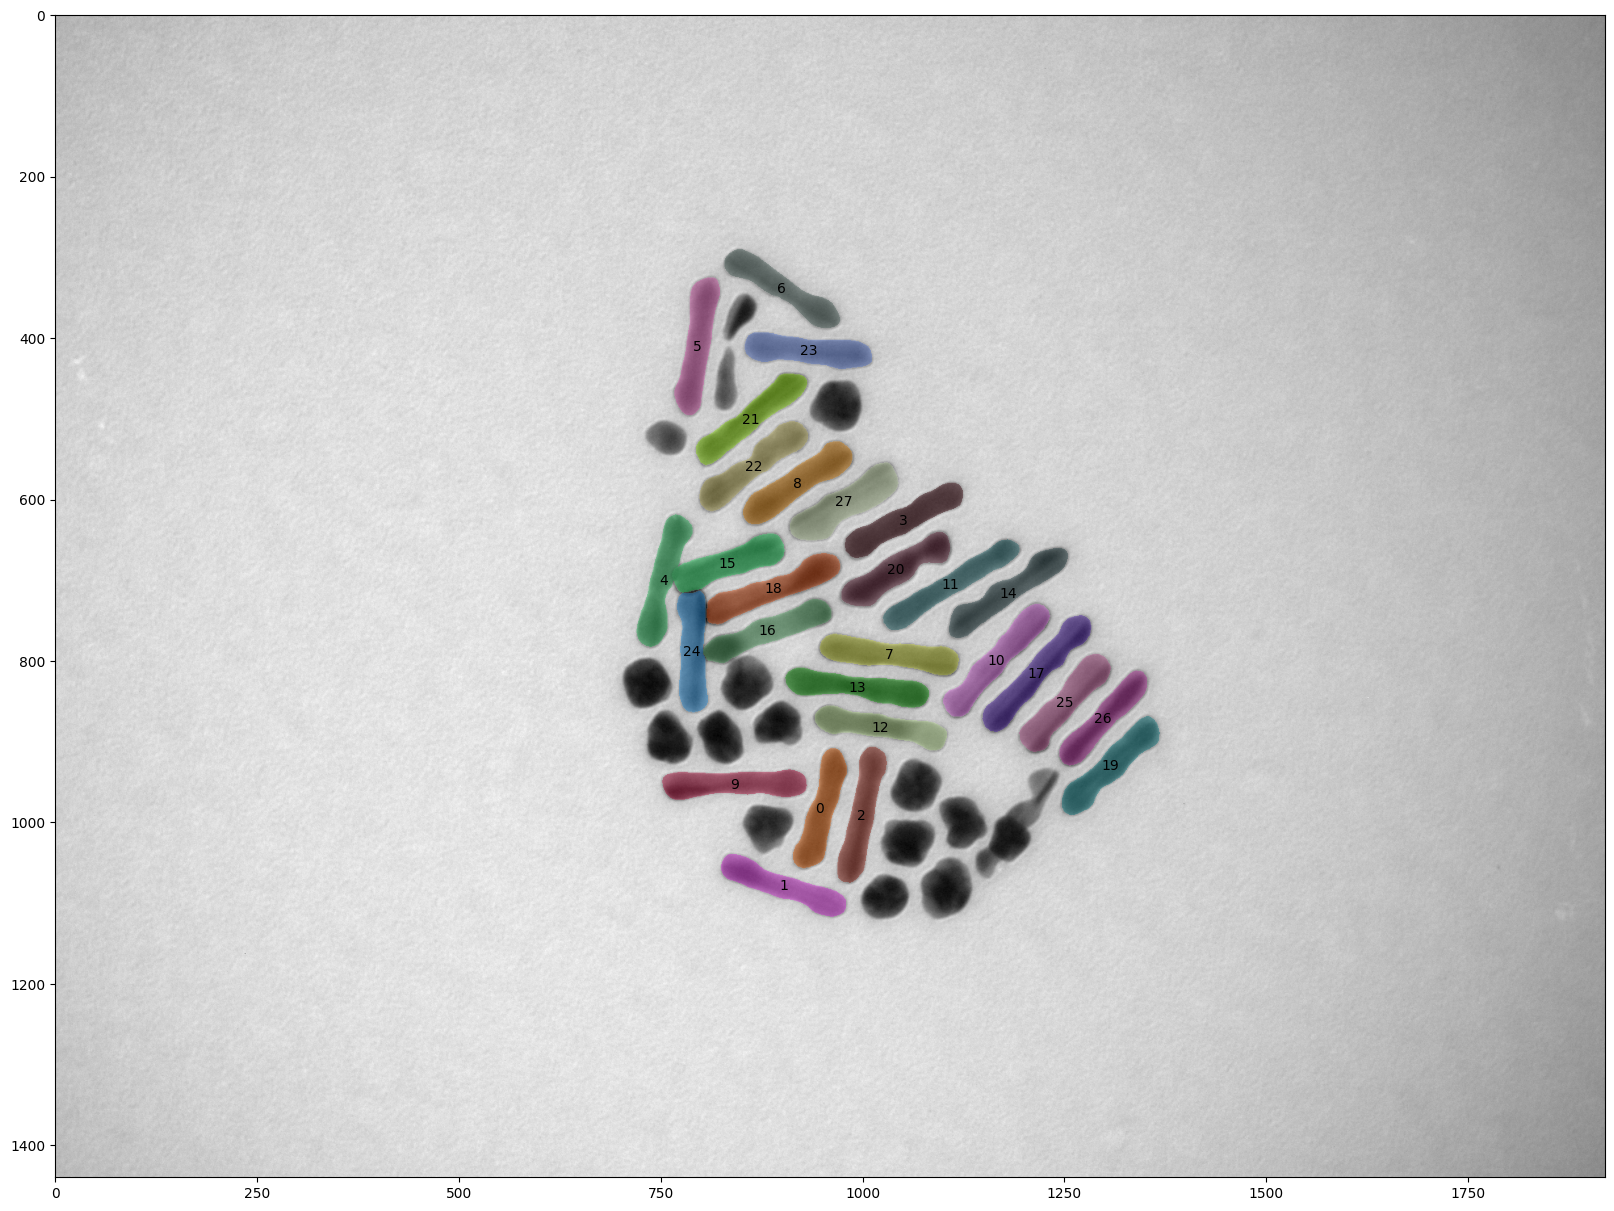

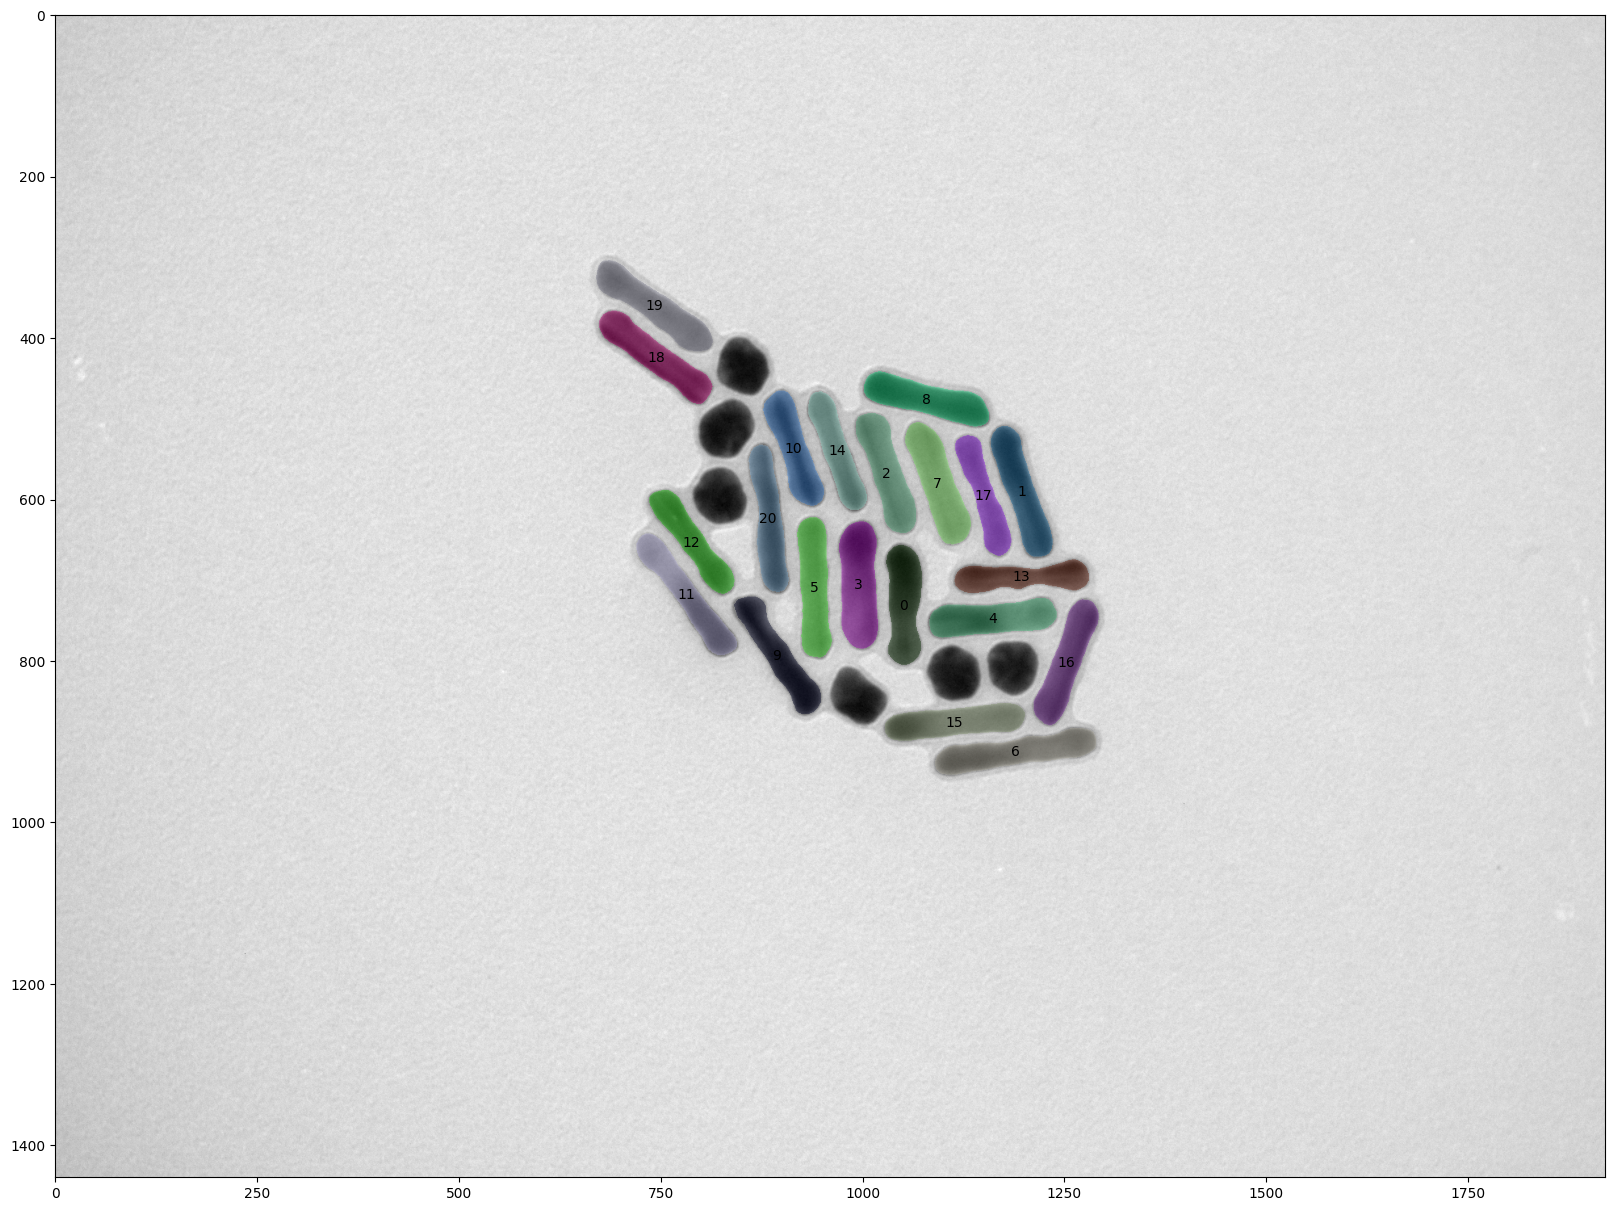

In [ ]:
# prompt: loop through all tif/png/jpg files in root folder, open image and pass image and image name to 'measure_single_image' function. concat each returned 'measurements' to a final dataframe

import pandas as pd
final_measurements_df = pd.DataFrame()

# Get a list of all files in the current directory
file_list = os.listdir('.')

# Filter for .tif, .jpg, .png files (case-insensitive)
image_files = [f for f in file_list if f.lower().endswith(('.tif', '.jpg', 'png'))]

os.makedirs('results', exist_ok=True)
for image_file in image_files:
    print(f"Processing image: {image_file}")
    # Open the image using cv2
    image = cv2.imread(image_file)
    if image is None:
        print(f"Could not open image {image_file}. Skipping.")
        continue

    # Convert the image from BGR (cv2 default) to RGB (as expected by SAM)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[:1440, :, :]

    # Get the base name without extension for the filename
    fname = os.path.splitext(image_file)[0]

    # Process the single image and get measurements
    measurements_df = measure_single_image(image, f'results/{fname}')

    # Add a column to indicate the original image file
    measurements_df['original_image'] = image_file

    # Concatenate the measurements to the final dataframe
    final_measurements_df = pd.concat([final_measurements_df, measurements_df], ignore_index=True)

final_measurements_df = final_measurements_df.sort_values(by=['original_image', '#'])
final_measurements_df.to_csv('results/measurements.csv')
print(f"Total number of detected rods: {len(final_measurements_df)}")
print(f"\nAverage length of rod: {final_measurements_df['rod_w'].mean():.2f}, STD length of rod: {final_measurements_df['rod_w'].std():.2f}")
print(f"\nAverage width of rod: {final_measurements_df['rod_h'].mean():.2f}, STD width of rod: {final_measurements_df['rod_h'].std():.2f}")
print(f"\nAverage effective ellipse diameter of rod: {final_measurements_df['rod_eff_d_ellipse'].mean():.2f}, STD: {final_measurements_df['rod_eff_d_ellipse'].std():.2f}")
print(f"\nAverage effective rectangular diameter of rod: {final_measurements_df['rod_eff_d_rec'].mean():.2f}, STD: {final_measurements_df['rod_eff_d_rec'].std():.2f}")
print(f"\nAverage number of dips per rod: {final_measurements_df['dip_cnt'].mean():.2f}, STD of number of dips per rod: {final_measurements_df['dip_cnt'].std():.2f}")

N = final_measurements_df['dip_cnt'].sum()
# Overall average
overall_sp_avg = (final_measurements_df['dip_cnt'] * final_measurements_df['dip_sp_avg']).sum() / N
overall_de_avg = (final_measurements_df['dip_cnt'] * final_measurements_df['dip_de_avg']).sum() / N
# Overall variance
overall_sp_var = ((final_measurements_df['dip_cnt'] * (final_measurements_df['dip_sp_std'] ** 2 + (final_measurements_df['dip_sp_avg'] - overall_sp_avg) ** 2)).sum()) / N
overall_de_var = ((final_measurements_df['dip_cnt'] * (final_measurements_df['dip_de_std'] ** 2 + (final_measurements_df['dip_de_avg'] - overall_de_avg) ** 2)).sum()) / N
# Overall standard deviation
overall_sp_std = np.sqrt(overall_sp_var)
overall_de_std = np.sqrt(overall_de_var)

print(f"\nAverage of spacing: {overall_sp_avg:.2f}, STD of spacing: {overall_sp_std:.2f}")
print(f"Average of depth: {overall_de_avg:.2f}, STD of depth: {overall_de_std:.2f}\n")